# Prepare

In [15]:
import torch

torch.cuda.empty_cache()

In [16]:
import argparse
import json
import os

import numpy as np
import sklearn.metrics
import torch
from torch import optim

from lib.suggested.self_attention_with_cnn import SelfAttentionCnnClassifier
from lib.embedding import load_full_embedding_with_vocab
from lib.reader import WikiqaReader, filtered_ref_generator
from lib.train import train_model, get_label_score
from lib.transformer import NoamOpt

In [17]:
config_path = 'models/suggested/self_attention_with_cnn/config.json'

In [18]:
with open(config_path, 'r') as fread:
    config_dict = json.load(fread)

# path
path_config = config_dict['Path']
model_dir = path_config['model_dir']
train = path_config['train']
dev = path_config['dev']
dev_ref = path_config['dev_ref']
test = path_config['test']
test_ref = path_config['test_ref']

words_embed, words_vocab = load_full_embedding_with_vocab(path_config['embed_dir'])
vocabs = {'q_words': words_vocab, 'a_words': words_vocab}

# model
model_config = config_dict['Model']
conv_width = model_config['conv_width']
out_channels = model_config['out_channels']
hidden_size = model_config['hidden_size']
cuda_device = model_config['cuda_device']
dropout = model_config['dropout']
h = model_config['h']

In [19]:
import importlib
import lib.suggested.self_attention_with_cnn
importlib.reload(lib.suggested.self_attention_with_cnn)

SelfAttentionCnnClassifier = lib.suggested.self_attention_with_cnn.SelfAttentionCnnClassifier

clf = SelfAttentionCnnClassifier(words_embed=words_embed, out_channels=out_channels,
            conv_width=conv_width, hidden_size=hidden_size, cuda_device=None,
            h=h, dropout=dropout)

In [20]:
clf.load_state_dict(torch.load(os.path.join(model_dir, 'net.pt')))

In [21]:
dev_reader = WikiqaReader(dev, PAD_TOKEN='<pad>')
dev_reader.set_vocabs(vocabs)

dev_iterator = dev_reader.get_dataset_iterator(10, train=True)

# gradient

In [30]:
from lib.train import train_model

In [31]:
optimizer = torch.optim.Adam(clf.parameters())

In [32]:
train_model(clf, optimizer, dev_iterator, label_name='label',
            num_epoch=1, cuda_device=None, early_stopping=0,
            input_names=['q_words', 'a_words'], callback=None, verbose=False)

---

In [33]:
print(clf.a_mha.linears[0].weight.grad)
print(clf.a_mha.linears[0].weight.grad.std())

tensor([[ 0.0004,  0.0035,  0.0047,  ..., -0.0024,  0.0007,  0.0052],
        [-0.0003, -0.0004,  0.0023,  ...,  0.0006,  0.0016,  0.0016],
        [ 0.0004, -0.0005, -0.0005,  ...,  0.0020, -0.0007, -0.0001],
        ...,
        [-0.0000,  0.0004,  0.0010,  ...,  0.0007, -0.0007,  0.0010],
        [-0.0028, -0.0024,  0.0004,  ...,  0.0005,  0.0039, -0.0007],
        [-0.0001, -0.0007,  0.0003,  ..., -0.0021, -0.0003,  0.0005]])
tensor(0.0013)


In [34]:
print(clf.q_mha.linears[0].weight.grad)
print(clf.q_mha.linears[0].weight.grad.std())

tensor([[ 0.0003,  0.0004,  0.0001,  ..., -0.0003, -0.0009,  0.0001],
        [-0.0001, -0.0001,  0.0004,  ..., -0.0006, -0.0002,  0.0004],
        [ 0.0000, -0.0008,  0.0006,  ..., -0.0012, -0.0003,  0.0010],
        ...,
        [ 0.0000,  0.0002,  0.0002,  ...,  0.0001, -0.0004, -0.0001],
        [-0.0002,  0.0000, -0.0005,  ...,  0.0002,  0.0003, -0.0003],
        [ 0.0001, -0.0002,  0.0001,  ..., -0.0003, -0.0001,  0.0002]])
tensor(0.0009)


# Attention Visualization

In [22]:
import matplotlib.pyplot as plt

In [42]:
q_words = dev_reader.dataset[34].q_words
a_words = dev_reader.dataset[34].a_words

In [105]:
clf.q_conv(clf.embed(torch.cat([q_words_in, q_words_in], dim=0)).transpose(1,2)).size()

torch.Size([2, 100, 6])

In [101]:
(torch.cat([q_words_in, q_words_in], dim=0) != 1).unsqueeze(-2).size()

torch.Size([2, 1, 6])

In [43]:
q_words_in = dev_reader.dataset.fields['q_words'].numericalize([q_words])
a_words_in = dev_reader.dataset.fields['a_words'].numericalize([a_words])

In [47]:
clf(q_words_in, a_words_in)

tensor([[ 1.0210, -1.3056]], grad_fn=<ThAddmmBackward>)

In [48]:
clf.q_mha.attn.size()

torch.Size([1, 10, 6, 21])

In [53]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(20, 20), dpi=80, facecolor='w', edgecolor='k')

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

In [41]:
clf.q_mha.attn[0][0].size()

torch.Size([11, 27])

In [ ]:
fig, ax = subplots(figsize=(18, 2))
ax.imshow(random.rand(8, 90), interpolation='nearest')
tight_layout()

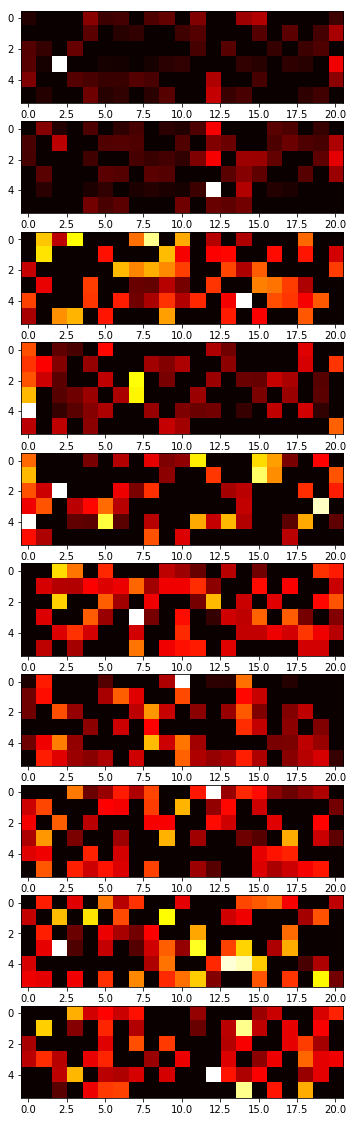

In [81]:
fig, ax = plt.subplots(nrows=10, figsize=(10, 20))
for i, row in enumerate(ax):
    row.imshow(clf.q_mha.attn[0][i].detach().numpy(), cmap='hot', interpolation='nearest',)
# plt.xticks(np.arange(len(a_words)), labels=a_words)
# plt.yticks(np.arange(len(q_words)), labels=q_words)

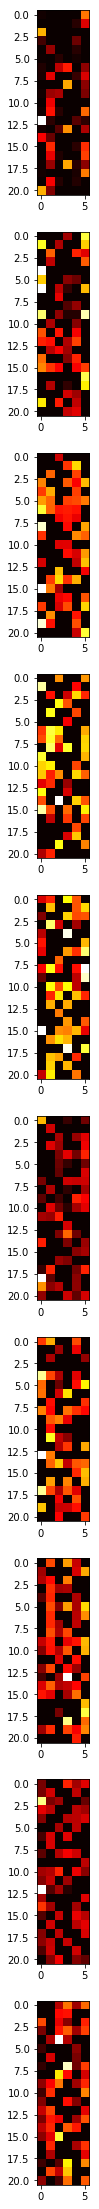

In [89]:
fig, ax = plt.subplots(nrows=10, figsize=(10, 40))
for i, row in enumerate(ax):
    row.imshow(clf.a_mha.attn[0][i].detach().numpy(), cmap='hot', interpolation='nearest',)
# plt.xticks(np.arange(len(a_words)), labels=a_words)
# plt.yticks(np.arange(len(q_words)), labels=q_words)

([<matplotlib.axis.YTick at 0x7fa4fd0756a0>,
 <a list of 6 Text yticklabel objects>)

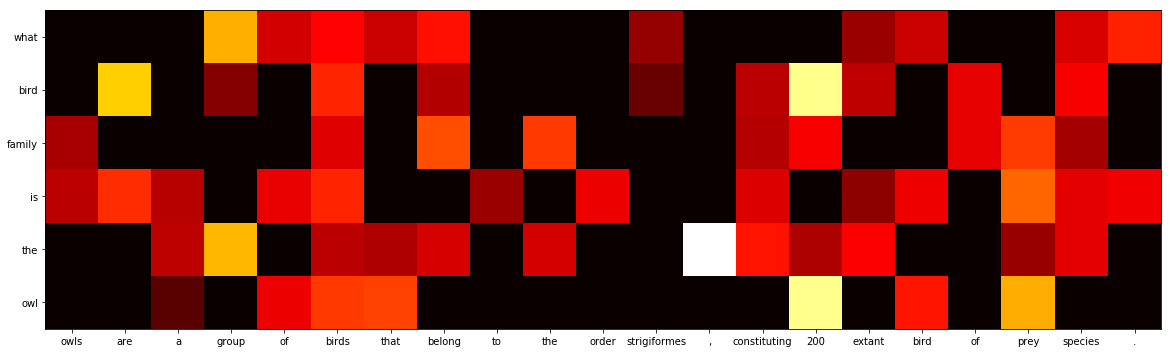

In [84]:
fig, ax = plt.subplots(figsize=(20, 20))

ax.imshow(clf.q_mha.attn[0][9].detach().numpy(), cmap='hot', interpolation='nearest',)
plt.xticks(np.arange(len(a_words)), labels=a_words)
plt.yticks(np.arange(len(q_words)), labels=q_words)

([<matplotlib.axis.YTick at 0x7fa4fd3ebf28>,
 <a list of 6 Text yticklabel objects>)

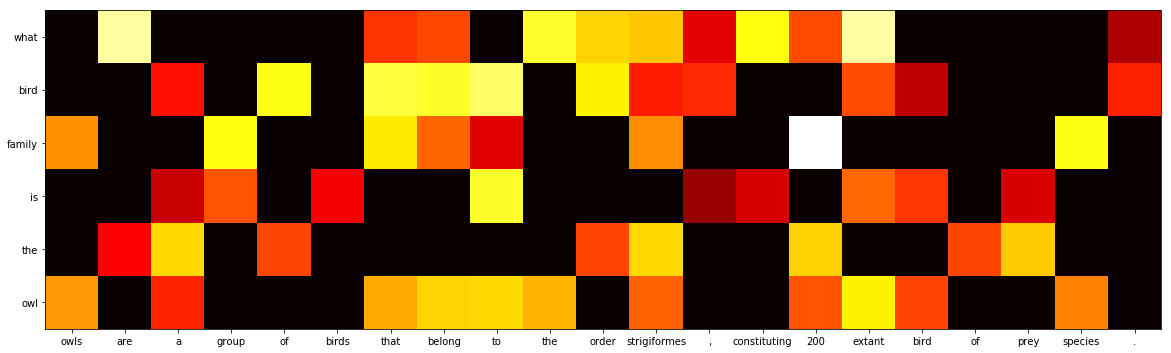

In [96]:
fig, ax = plt.subplots(figsize=(20, 20))

ax.imshow(clf.a_mha.attn[0][3].detach().numpy().transpose(), cmap='hot', interpolation='nearest',)
plt.xticks(np.arange(len(a_words)), labels=a_words)
plt.yticks(np.arange(len(q_words)), labels=q_words)